In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import schedulers

from time import perf_counter

import pandas as pd
import numpy as np

from superonn_final import SuperONN2d

import matplotlib.pyplot as plt

In [2]:
def randomshift_1d(x, shifts, learnable, max_shift, rounded_shifts, padding_mode="zeros"):
    x = x.moveaxis(0, 1)
    x = x.unsqueeze(-1)
    # Take the shape of the input
    c, _, h, w = x.size()

    # Clamp the center bias in case of too much shift after back-propagation
    if learnable:
        torch.clamp(shifts, min=-max_shift, max=max_shift)

        # Round the biases to the integer values
        if rounded_shifts:
            torch.round(shifts)

    # Normalize the coordinates to [-1, 1] range which is necessary for the grid
    a_r = torch.zeros_like(shifts[:, :1])
    b_r = shifts[:, 1:] / (h / 2)

    # Create the transformation matrix
    aff_mtx = torch.eye(3).to(x.device)
    aff_mtx = aff_mtx.repeat(c, 1, 1)
    aff_mtx[..., 0, 2:3] += a_r
    aff_mtx[..., 1, 2:3] += b_r

    # Create the new grid
    grid = F.affine_grid(aff_mtx[..., :2, :3], x.size(), align_corners=False)

    # Interpolate the input values
    x = F.grid_sample(x, grid, mode='bilinear', padding_mode=padding_mode, align_corners=False)
    x = x.squeeze(-1)
    x = x.moveaxis(0, 1)
    return x

In [3]:
def randomshift(x, shifts, learnable, max_shift, rounded_shifts, padding_mode="zeros"):
    x = x.moveaxis(0, 1)
    # Take the shape of the input
    c, _, h, w = x.size()

    # Clamp the center bias in case of too much shift after back-propagation
    if learnable:
        torch.clamp(shifts, min=-max_shift, max=max_shift)

        # Round the biases to the integer values
        if rounded_shifts:
            torch.round(shifts)

    # Normalize the coordinates to [-1, 1] range which is necessary for the grid
    a_r = shifts[:, :1] / (w / 2)
    b_r = shifts[:, 1:] / (h / 2)

    # Create the transformation matrix
    aff_mtx = torch.eye(3).to(x.device)
    aff_mtx = aff_mtx.repeat(c, 1, 1)
    aff_mtx[..., 0, 2:3] += a_r
    aff_mtx[..., 1, 2:3] += b_r

    # Create the new grid
    grid = F.affine_grid(aff_mtx[..., :2, :3], x.size(), align_corners=False)

    # Interpolate the input values
    x = F.grid_sample(x, grid, mode='bilinear', padding_mode=padding_mode, align_corners=False)
    x = x.moveaxis(0, 1)
    return x

In [4]:
x = torch.arange(100).view(1, 1, 10, 10).float() / 100
x = x.repeat(1, 4, 1, 1)
shifts = torch.tensor([[5, 0], [-5, 0], [0, 5], [0, -5]])
shifted_x = randomshift(x, shifts, learnable=False, max_shift=10, rounded_shifts=False)

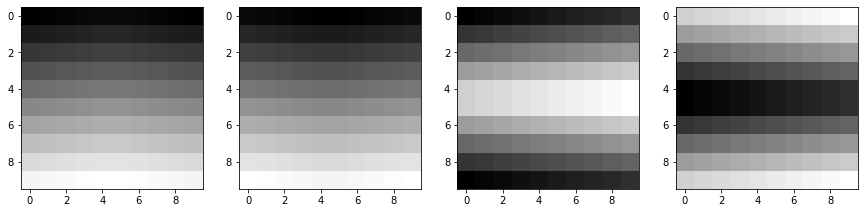

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(shifted_x[0,0], cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(shifted_x[0,1], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(shifted_x[0,2], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(shifted_x[0,3], cmap='gray')

In [6]:
x = torch.arange(10).repeat(5, 2).view(2, 5, 10)
shifts = torch.arange(2).view(-1, 1)
randomshift_1d_differentiable(x, shifts, learnable=False, max_shift=10, rounded_shifts=False)

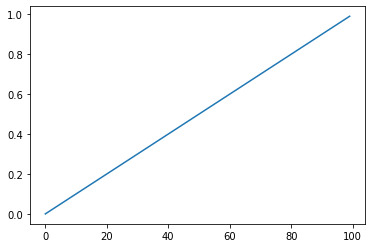

In [7]:
a = torch.eye(3)
a = a.repeat(3, 1, 1)
a[..., 2:3] = 5
a

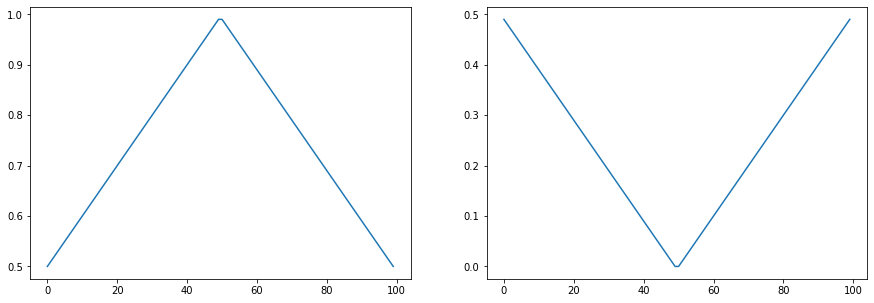

In [8]:
a = torch.tensor([1,3,2,2,3])
b = torch.tensor([0,2,1,1,2])
torch.repeat_interleave(b, a)

In [8]:
x = torch.ones(1,3,2,2)
x[:, 0, :, :] = 2
x[:, 1, :, :] = 3
x[:, 2, :, :] = 4

q = 1

# we want    2, 4, 8 - 3, 9, 27 - 4, 16, 64
# instead of 2, 3, 4 - 4, 9, 16 - 8, 27, 64

In [8]:
def take_qth_power(x, q, dim=1, with_w0=False):
    if with_w0:
        powers = torch.arange(0, q+1, device=x.device).repeat(x.shape[dim])
        x = x.repeat_interleave(q+1, dim=dim)
    else:
        powers = torch.arange(1, q+1, device=x.device).repeat(x.shape[dim])
        x = x.repeat_interleave(q, dim=dim)
    y = torch.pow(x.transpose(dim, -1), powers)
    y = y.transpose(dim, -1)
    return y

def take_qth_power_v2(x, q, dim=1, with_w0=False):
    N, C, H, W = x.shape
    start = 0 if with_w0 else 1
    total = q+1 if with_w0 else q
    x = torch.cat([x**i for i in range(start, q+1)], dim=1)
    x = x.reshape(N, total, C, H, W).transpose(1, 2).reshape(N, C*total, H, W)
    return x

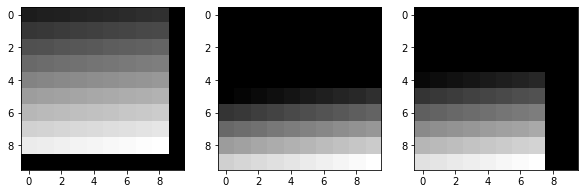

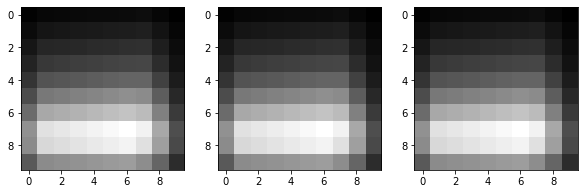

In [148]:
take_qth_power_v2(x, q, with_w0=False)

tensor([[[ 4.],
         [ 0.],
         [-3.]]], grad_fn=<MulBackward0>) torch.Size([1, 3, 1])


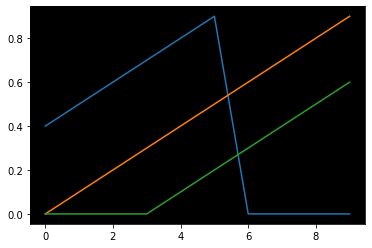

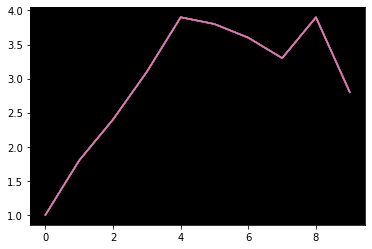

In [155]:
def take_qth_power(x, q, powers=None, dim=1, with_w0=False):
    if with_w0:
        powers = torch.arange(0, q+1, device=x.device).repeat(x.shape[dim])
        x = x.repeat_interleave(q+1, dim=dim)
    else:
        powers = torch.arange(1, q+1, device=x.device).repeat(x.shape[dim])
        x = x.repeat_interleave(q, dim=dim)
    y = torch.pow(x.transpose(dim, -1), powers)
    y = y.transpose(dim, -1)
    return y

In [96]:
son = SuperONN2d(3, 3, kernel_size=5, padding=5//2, q=2, shift_init='random_int', max_shift=10)
son.shifts

torch.Size([5, 7, 12])


In [24]:
x = torch.randn(2, 3, 4, 4, device='cuda')

RuntimeError: grid_sampler_2d_cpu not implemented for Long

In [ ]:
q = 3
y1 = torch.cat([x**i for i in range(1, q+1)], dim=1)
y11 = torch.pow(x.repeat((1,q,1,1)).transpose(1, -1), torch.arange(1, q+1, device=x.device).repeat_interleave(x.shape[1])).transpose(1, -1)
y2 = take_qth_power(x, q, dim=1, with_w0=False)

In [ ]:
%%timeit
y1 = torch.cat([x**i for i in range(1, q+1)], dim=1)

In [ ]:
%%timeit
y11 = torch.pow(x.repeat((1,q,1,1)).transpose(1, -1), torch.arange(1, q+1, device=x.device).repeat_interleave(x.shape[1])).transpose(1, -1)

In [ ]:
powers = torch.arange(1, q+1, device=x.device).repeat(x.shape[1])

In [ ]:
%%timeit
y2 = take_qth_power(x, q, powers, dim=1, with_w0=False)

In [ ]:
s = SuperONN2d(64, 64, q=3, kernel_size=3, padding=1, groups='depthwise', full_groups=2)

In [ ]:
batch_size = 2
channels = 3
height = 5
width = 5
inputs = 2*torch.ones(batch_size, channels, height, width)

In [ ]:
out = torch.pow(inputs.permute(0,2,3,1),torch.tensor([1,2,3]))

In [ ]:
out = out.permute(0,3,1,2)

In [ ]:
out.repeat((1,3,1,1))
torch.arange(1,4).repeat(inputs.shape[1])


In [ ]:
def take_qth_power(x, q, dim=1, with_ones=False):
    if with_ones:
        powers = torch.arange(0, q+1).repeat(x.shape[dim])
        x = x.repeat_interleave(q+1, dim=dim)
    else:
        powers = torch.arange(1, q+1).repeat(x.shape[dim])
        x = x.repeat_interleave(q, dim=dim)
    y = torch.pow(x.transpose(dim, -1), powers)
    y = y.transpose(dim, -1)
    return y

In [ ]:
import torch

# Create input tensor of shape (batch_size, channels, height, width)
batch_size = 2
channels = 3
height = 2
width = 2
x = 2*torch.ones(batch_size, channels, height, width)
q = 2

y = take_qth_power(x, q, with_ones=True)
print(y.shape)

In [ ]:
sonn2d = SuperONN2d(3, 3, kernel_size=3, padding=1, q=2)

In [ ]:
x = torch.randn(2, 3, 4, 4)
x = (x - x.amin(dim=(2,3), keepdim=True)) / (x.amax(dim=(2,3), keepdim=True) - x.amin(dim=(2,3), keepdim=True))
sonn2d(x)

In [ ]:
class A:
    from math import gcd
    from sklearn.metrics import roc_auc_score

    def do(self, x, y):
        print(self.roc_auc_score(y_true=[0,1,1,0], y_score=[0.2,0.3,0.4,0.5]))
        return self.gcd(x, y)

In [ ]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=[0,1,1,0], y_score=[0.2,0.3,0.4,0.5]))

In [ ]:
A().do(10, 5)

In [ ]:
x = torch.randn(1, 3, 5, 5)
torch.amax(x, dim=1, keepdim=True)

In [ ]:
nn.Conv2d(4, 2, 5, padding=2, groups=1).weight.shape

In [ ]:
sup2d = SuperONN2d(3, 3, 3, padding=2, q=2, bias=False, with_w0=True)

In [ ]:
sup2d.weight.shape

In [ ]:
x = torch.randn(1, 3, 32, 32)

In [ ]:
sup2d_out = sup2d(x)

In [ ]:
plt.imshow(x.squeeze().permute(1,2,0))

In [ ]:
plt.imshow(sup2d_out.detach().squeeze().permute(1,2,0))

In [ ]:
SuperONN2d(4, 2, 5, padding=2, q=2).shifts.shape

In [ ]:
# All channels are shifted by the same amount (e.g. RGB)
SuperONN2d(4, 2, 5, padding=2, q=2, shift_groups=1).shifts.shape

In [ ]:
# First half and the second half have different shifts
SuperONN2d(4, 2, 5, padding=2, q=2, shift_groups=2).shifts.shape

In [ ]:
# By default, shift_groups = in_channels = 4
SuperONN2d(4, 2, 5, padding=2, q=2, shift_groups=4).shifts.shape

In [ ]:
# Reduces complexity by a factor of 'groups'
SuperONN2d(9, 18, 5, padding=2, q=2, groups=18).weight.shape

In [ ]:
# Semi-mode BUT 'shift_groups' of neurons have different shifts
# AND neurons process channels raised to different powers
SuperONN2d(9, 18, 5, padding=2, q=2, groups=18, shift_groups=3).shifts.shape

In [ ]:
SuperONN2d(9, 18, 5, padding=2, q=1, full_groups=6).shifts.shape

In [ ]:
SuperONN2d(9, 18, 5, padding=2, q=3, full_groups=6, groups=6, shift_groups=3).weight.shape

In [ ]:
SuperONN2d(3, 24, 5, padding=2, q=2, full_groups=4, groups=12, shift_groups=3).weight.shape

In [ ]:
for in_c in [3, 8, 16, 64]:
    for out_c in [3, 8, 16, 64]:
        for q in [2, 3, 4, 5, 6, 7]:
            for full_groups in range(out_c):
                for groups in range(min(out_c, in_c * q * full_groups)):
                    for shift_groups in range(in_c):
                        x = torch.randn(1, in_c, 5, 5)

                        try:
                            sonn = SuperONN2d(
                                in_c, 
                                out_c,
                                kernel_size=3,
                                padding=1,
                                q=q,
                                full_groups=full_groups,
                                groups=groups,
                                shift_groups=shift_groups,
                                max_shift=10,
                                learnable=True
                            )
                            conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, groups=groups)
                        except Exception as e:
                            continue

                        try:
                            outconv = conv(x)
                            outsonn = sonn(x)
                        except:
                            print(f"in_c={in_c}, out_c={out_c}, q={q}, full_groups={full_groups}, groups={groups}, shift_groups={shift_groups}")
                            raise Exception("Passing through conv/sonn failed")
                        
                        if not torch.equal(torch.tensor(outconv.shape), torch.tensor(outsonn.shape)):
                            raise Exception("Shapes don't match")
                        
                        sonnw = torch.tensor(sonn.weight.shape)
                        convw = torch.tensor(conv.weight.shape)

                        sonnw[1] = sonnw[1] * (sonn.groups // sonn.full_groups) // sonn.q // groups

                        if not torch.equal(sonnw, convw):
                            print(f"sonnw={sonnw}, convw={convw}")
                            print(f"in_c={in_c}, out_c={out_c}, q={q}, full_groups={full_groups}, groups={groups}, shift_groups={shift_groups}")
                            raise Exception("Weights don't match")

In [ ]:
def do_runtime_test(models, x, device, repeats):
    assert device != "cuda" or torch.cuda.is_available(), "CUDA not available"

    models = {k: v.to(device) for k, v in models.items()}
    x = x.to(device)

    # warmup
    for model in models:
        for _ in range(10):
            y = models[model](x)
        torch.cuda.synchronize()

    runtimes = {}
    for model in models:
        start = perf_counter()
        for _ in range(repeats):
            y = models[model](x)
        torch.cuda.synchronize()
        end = perf_counter()
        runtimes[model] = end - start

    return runtimes

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
x = torch.randn(1, 64, 25, 25).to(device)

In [ ]:
models = {
    "sonn": SuperONN2d(64, 64, q=3, kernel_size=3, padding=1, groups=1, max_shift=10, learnable=True).to(device),
    "sonn_dw": SuperONN2d(64, 64, q=3, kernel_size=3, padding=1, groups=64, full_groups=1, max_shift=10, learnable=True).to(device),
    "sonn_full": SuperONN2d(64, 64, q=3, kernel_size=3, padding=1, full_groups=8, groups=8, max_shift=10, learnable=True).to(device),
    "sonn_full_dw": SuperONN2d(64, 64, q=3, kernel_size=3, padding=1, full_groups=8, groups=64, max_shift=10, learnable=True).to(device),
}

In [ ]:
params = {
    key: sum(list(map(lambda x: x.numel(), model.parameters()))) for key, model in models.items()
}

In [ ]:
gpu_runtimes = do_runtime_test(models, x, device, repeats=1000)
cpu_runtimes = do_runtime_test(models, x, "cpu", repeats=1000)

In [ ]:
gpu_runtimes

In [ ]:
cpu_runtimes

In [ ]:
data = {model: [params[model], gpu_runtimes[model], cpu_runtimes[model], models[model].defaults] for model in models}

In [ ]:
pd.DataFrame(data, index=["params", "gpu", "cpu", "params"]).T.to_csv("superonn_final_runtimes.csv")

In [ ]:
# Shift repeat test
# shift_groups = 3, in_channels = 12
shifts = torch.tensor([[0, 1, 2], [0, 1, 2]]).T
new_shifts = torch.repeat_interleave(shifts, 12 // 3, 0)

assert shifts.shape == (3, 2)
assert new_shifts.shape == (12, 2)
assert torch.allclose(shifts[0, :], new_shifts[0:4, :])
print(shifts)
print(new_shifts)

In [ ]:
# Reshape test
n = 1
in_c = 2
out_c = 3
h = 2
w = 2

# A 2x2 image with 2 channels, one of them is all 1s and the other is all 2s.
x = torch.tensor([1,1,1,1,2,2,2,2]).reshape(n, in_c, h, w)
print(x, x.shape)

# Concat the channels out_c times.
y = torch.cat([x for _ in range(out_c)], 1)
print(y, y.shape)

# Now, should we reshape it to (n, in_c, out_c, h, w) or (n, out_c, in_c, h, w)?
# (n, out_c, in_c, h, w) is the correct shape, as we have (n x out_c) images with in_c channels, not (n x in_c) images with out_c channels.
z = y.reshape(n, out_c, in_c, h, w)
print(z)

In [ ]:
# Shift reshape test
in_channels = 4
full_groups = 3
shift_groups = 2
shifts = torch.tensor([[[0, 1, 2], [0, 1, 2]], [[0, 1, 2], [0, 1, 2]]]).T
print(shifts.shape)

new_shifts = torch.repeat_interleave(shifts, in_channels // shift_groups, 1)
print(new_shifts.shape)

print(shifts.reshape(full_groups * shift_groups, 2))
print(new_shifts.reshape(full_groups * in_channels, 2))

In [ ]:
torch.cat(x.tile(4).chunk(4, -1), 1)